# Loop trough CMIP6 models

In [1]:
import numpy as np
import glob
import os
from cdo import Cdo
import sys
import subprocess as sp
import intake
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm 
import xarray as xr
import pandas

import plotting_helpers as ph

sys.path.append("/home/u/u301557/UHH-CMIP6/scripts")
from functions.FUNC_CreateModellist import MODELLIST
from functions.FUNC_CreateModellist import MODELLIST_from_list
from functions.FUNC_ModelSearch import ModelSearch
import functions.STOR_CMIP6 as STOR_CMIP6

sys.path.append("/home/u/u301557/UHH-Sat-SIA/scripts")
from functions.logger_functions import *

cdo = Cdo()
os.system('module load nco')
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

print("DONE")

DONE


In [2]:
variable   = "fgco2" # sia or sie

scenarios  =  ['ssp119','ssp126','ssp245','ssp460','ssp370','ssp585', 'piControl','historical']
subfolders = STOR_CMIP6.subfolders # Dictionary with names for the subfolders for each scenario 
    
domain     = "Omon"

basepath       = '/pool/data/CMIP6/data/'                                         # where CMIP6 model data is stored

outpath        = "/work/uo1227/u301557/ArcticCarbon/data/fgco2/"                     # test outpath

#gridpath       = '/work/uo1227/DATA/modelling/CMIP6/gridareas/'                   # where the gridarea files are strored
gridpath       = '/work/uo1227/u301557/ArcticCarbon/data/gridarea/'
temppath       = '/work/uo1227/u301557/temp/'                                     # temporary strorage for "mergetime"    
ocean_maskpath = "/work/uo1227/u301557/ArcticCarbon/data/ocean-masks-remap/"
AO_mask = "/home/u/u301557/ArcticCarbon/Arctic_ocean_mask_regions.nc"

print("SETUP:")
print("- "+variable+" - "+ outpath)

SETUP:
- fgco2 - /work/uo1227/u301557/ArcticCarbon/data/fgco2/


In [3]:
def file_existence(filepath, logger):
    filename = filepath.split("/")[-1]
    
    if os.path.isfile(filepath):
        logger.debug("created " + filename)
    else:
        logger.error("failed to create " + filename)

In [4]:
def cal_annual_flux(model, ensemblemember, scenario):

    gridtype = [os.path.basename(x) for x in glob.glob(inpath+modelcenter+'/'+model+'/'+scenario+'/'
                                                   +ensemblemember+'/'+domain+'/'+variable+'/*')][0]
    av_versions = [os.path.basename(x) for x in glob.glob(inpath+modelcenter+'/'+model+'/'+scenario+'/'
                                                          +ensemblemember+'/'+domain+'/'+variable+'/'+gridtype+'/v*')]
    if 'v1' in av_versions:
        version = 'v1'
    else:
        version = 'v'+str(np.max([int(v[1::]) for v in av_versions]))
    
    inputfile = inpath+modelcenter+'/'+model+'/'+scenario+'/'+ensemblemember+'/'+domain+'/'+variable+'/'+gridtype+'/'+version+'/*.nc'

    # find area file
    logger.debug(gridpath + f"{model}_areacello_{gridtype}_*")
    try:
        area_file = glob.glob(gridpath + f"{model}_areacello_{gridtype}_*")[0]
    except:
        logger.error(f"area file is missing: {gridpath}{model}_areacello_{gridtype}_*")
        return

    # remap mask
    remapped_mask = ocean_maskpath + f"{model}_arctic-ocean-mask_remapped.nc"
    if not os.path.isfile(remapped_mask):
        examplefile = glob.glob(inputfile)[0]        
        cdo.copy(input = f" -remapbil,{area_file} -selvar,arctic_mask {AO_mask}", output=remapped_mask)
        file_existence(remapped_mask, logger)

    # Arctic Ocean RECCAP2 mask
    logger.debug(remapped_mask)
    logger.debug(area_file)
    logger.debug(inputfile)

    cdo.fldsum(input = f" -ifthen {remapped_mask} -setattribute,fgco2@units='Pg yr-1' -chname,areacello,fgco2 -divc,1e12 -yearsum -mulc,2592000 -mul {area_file} -mergetime {inputfile}", output=outpath +f"{variable}_AO_{model}_{ensemblemember}_{scenario}.nc", options ="--reduce_dim")
    file_existence(outpath +f"{variable}_AO_{model}_{ensemblemember}_{scenario}.nc", logger)

    # Arctic above 60°N
    cdo.fldsum(input = f" -masklonlatbox,0,360,60,90 -setattribute,fgco2@units='Pg yr-1' -chname,areacello,fgco2 -divc,1e12 -yearsum -mulc,2592000 -mul {area_file} -mergetime {inputfile}", output=outpath +f"{variable}_60_{model}_{ensemblemember}_{scenario}.nc", options ="--reduce_dim")
    file_existence(outpath +f"{variable}_60_{model}_{ensemblemember}_{scenario}.nc", logger)


In [31]:
logging_level = "debug"
logger = build_terminal_logger(logging_level, logger_name="fgco2")

In [33]:
not_processed = []
scenarios = ["historical"]

for scenario in scenarios[:]:
    logger.info(scenario)
    #print("##########   " + scenario +"   ##########")
    availmodels, modelcenters, inpath = ModelSearch(scenario) # change to intake to only loop over models that have this (or all variables)
    
    for modelcenter in tqdm(modelcenters[15:16], leave=True): #modelcenters[:10]
        for model in availmodels[scenario][modelcenter]: 
            logger.info(modelcenter +" "+ model)
            ensemblemembers = [os.path.basename(x) for x in glob.glob(inpath+modelcenter+'/'+model+'/'+scenario+'/r*i1p1f*')] # get the ensemblemmebers
            ensemblemembers = sorted(ensemblemembers, key=lambda s: int(re.findall(r'\d+', s)[0]))
            if len(ensemblemembers) ==0:
                logger.debug("--- No data in this run")
                
            for ensemblemember in ensemblemembers[:1]:
                outputfile = f"{outpath}{variable}_AO_{model}_{ensemblemember}_{scenario}.nc"
                if os.path.isfile(outputfile):
                    logger.debug(f"--- File already exists ({ensemblemember}).")
                    pass
                elif not any(x in [variable]  for x in  [x.split('/')[-1] for x in glob.glob(inpath+modelcenter+'/'+model+'/'+scenario+'/'+ensemblemember+'/'+domain+'/*')]):
                    logger.debug(f"--- {variable} does not exsist for the model run ({ensemblemember}).")
                    pass
                else:
                    cal_annual_flux(model, ensemblemember, scenario)
                    logger.info(ensemblemember)
                
print(len(not_processed))
print("done")

historical
  0%|          | 0/1 [00:00<?, ?it/s]MOHC HadGEM3-GC31-LL
--- fgco2 does not exsist for the model run (r1i1p1f3).
MOHC HadGEM3-GC31-MM
--- fgco2 does not exsist for the model run (r1i1p1f3).
MOHC UKESM1-0-LL
--- File already exists (r1i1p1f2).
100%|██████████| 1/1 [00:00<00:00, 237.56it/s]

0
done


In [30]:
gridpath

'/work/uo1227/DATA/modelling/CMIP6/gridareas/'

In [63]:
remapped_mask = "/work/uo1227/u301557/ArcticCarbon/data/ocean-masks-remap/MIROC-ES2L_arctic-ocean-mask_remapped.nc"
area_file     = "/work/uo1227/DATA/modelling/CMIP6/gridareas/MIROC-ES2L_areacello_gn_calc.nc"
inputfile     = "/pool/data/CMIP6/data/CMIP/MIROC/MIROC-ES2L/historical/r1i1p1f2/Omon/fgco2/gr1/v20200731/*.nc"

#cdo.fldsum(input = f" -ifthen {remapped_mask} -setattribute,fgco2@units='Pg yr-1' -chname,areacello,fgco2 -divc,1e12 -yearsum -mulc,2592000 -mul {area_file} -mergetime {inputfile}", output=f"test.nc", options ="--reduce_dim")
cdo.fldsum(input = f" -ifthen {remapped_mask} -setattribute,fgco2@units='Pg yr-1' -chname,areacello,fgco2 -divc,1e12 -yearsum -mulc,2592000 -mergetime {inputfile}", output=f"test.nc", options ="--reduce_dim")

#cdo.mul(area_file, input = f" -mul {area_file} -mergetime {inputfile}", output=f"test.nc", options ="--reduce_dim")
#output = cdo.mul(area_file+" "+inputfile, output="test.nc", options="--reduce_dim")

file_existence("test.nc", logger)

created test.nc


In [60]:
import subprocess
file = glob.glob(inputfile)[0]
command = f"cdo mul {remapped_mask} {file} test.nc"
output = subprocess.check_output(command, shell=True, text=True)


cdo    mul (Abort): Grid size of the input parameter arctic_mask do not match!


CalledProcessError: Command 'cdo mul /work/uo1227/u301557/ArcticCarbon/data/ocean-masks-remap/MIROC-ES2L_arctic-ocean-mask_remapped.nc /pool/data/CMIP6/data/CMIP/MIROC/MIROC-ES2L/historical/r1i1p1f2/Omon/fgco2/gr1/v20200731/fgco2_Omon_MIROC-ES2L_historical_r1i1p1f2_gr1_185001-201412.nc test.nc' returned non-zero exit status 1.

In [36]:
outpath

'/work/uo1227/u301557/ArcticCarbon/data/fgco2/'

In [40]:
files_60 = glob.glob(outpath + "*60*.nc")
files_AO = glob.glob(outpath + "*AO*.nc")

In [95]:
def files_to_dataframe(files):
    years = np.arange(1850, 2015)
    df = pd.DataFrame({"year":years})#
    
    for file in files:
        model = file.split("/")[-1].split("_")[-3]
        ds = xr.open_dataset(file)
        df[model] = ds.fgco2.values
        ds.close()
    
    df = df.set_index("year")

    return df

In [96]:
df_60 = files_to_dataframe(files_60)
df_AO = files_to_dataframe(files_AO)

In [111]:
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in np.linspace(0, 1, 24)]
color_models = {}
for model, color in zip(df_AO.columns, colors):
    print(color)
    color_models[model] = color

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)
(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
(1.0, 0.7333333333333333, 0.47058823529411764, 1.0)
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
(0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
(1.0, 0.596078431372549, 0.5882352941176471, 1.0)
(0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)
(0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0)
(0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)
(0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0)
(0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0)
(0.9686274509803922, 0.7137254901960784, 0.82352

In [110]:
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.96862745098039

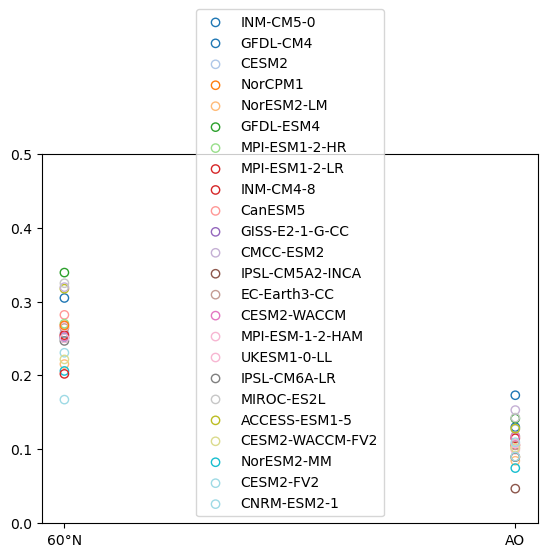

In [115]:
for model, value in df_60.loc[2005:2014].mean(axis=0).items():
    plt.scatter(1, value, facecolors='none', edgecolor=color_models[model], marker="o")

for model, value in df_AO.loc[2005:2014].mean(axis=0).items():
    plt.scatter(2, value, label=model, facecolors='none', edgecolor=color_models[model], marker="o")
 
plt.ylim(0,0.5)
plt.xticks([1,2], ["60°N", "AO"])
plt.legend()

(0.0, 0.5)

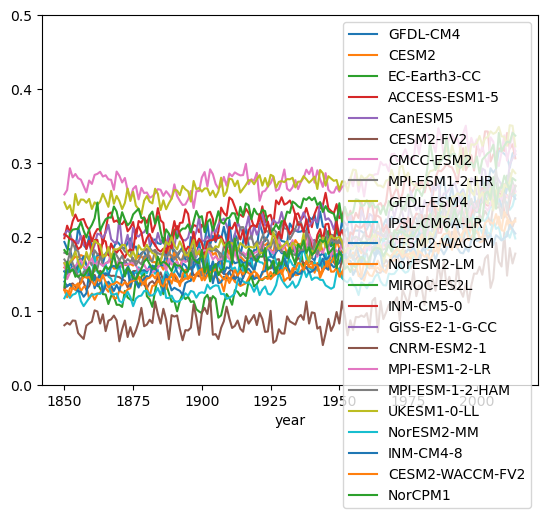

In [54]:
df_60.plot()
plt.ylim(0,0.5)